# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from tqdm import tqdm

import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    from tools import lstm
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(defs)
    reload(params)
finally:
    os.chdir(nbPath)
    
if "__file__" not in dir():
    print('Done!')

Done!


# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)
    
clear_output()

# Decoding


## Within animal, within session

Same as *"within-day"* analysis of the NN paper

In [4]:
reg_scores = []

for i, df in enumerate(AllDFs):
    AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[1], n_components=defs.n_components)
    # adding history
    AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
    
    _,_,n_trial,n_time,n_comp = AllData.shape
    half_trials = int(n_trial /2)
    AllData1 = AllData[0,...][:,:half_trials, :,:]
    AllData2 = AllData[0,...][:,-half_trials:,:,:]
    AllVel1 = AllVel[0,...][:,:half_trials, :,:]
    AllVel2 = AllVel[0,...][:,-half_trials:,:,:]
    
    # resizing
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,3))
    AllVel1 = AllVel1.reshape((-1,3))
    #remove NaNs from the data 
    nanIndex = np.isnan(AllVel1.T).nonzero()[1]
    nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
    goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
    # print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')
  
    # train the decoder
    Y_train_x,Y_train_y, Y_train_z = AllVel1.T[:,goodIndex]
    Y_test_x,Y_test_y, Y_test_z = AllVel2.T[:,goodIndex]

    x_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=10).mean()
    y_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=10).mean()
    z_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_z,Y_test_z)),scoring=defs.custom_r2_scorer, cv=10).mean()
    
    reg_scores.append((i,(x_score,y_score,z_score)))

pop_score_day = []
for _,scores in reg_scores:
    pop_score_day.append(np.mean(scores))
pop_score_day = np.array(pop_score_day)

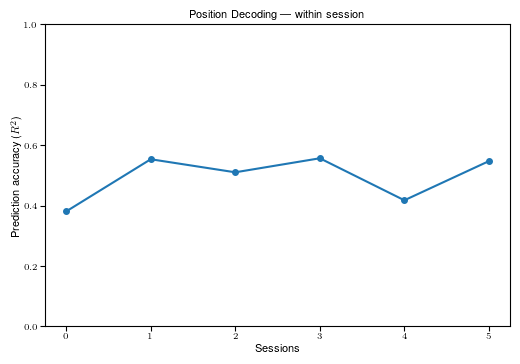

In [5]:
if "__file__" not in dir():

    _,ax = plt.subplots(dpi=100)
    ax.plot(pop_score_day,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Sessions');
    ax.set_ylabel('Prediction accuracy ($R^2$)');
    ax.set_title('Position Decoding --- within session');

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [6]:
pairIndex_across = []
for i, df1 in enumerate(AllDFs):
    animal1 = df1.mouse[0]
    pairIndex_across.append((i,[]))
    for j, df2 in enumerate(AllDFs):
        if j<i: continue
        animal2 = df2.mouse[0]
        if animal1 == animal2: continue
        pairIndex_across[-1][1].append(j)
pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

In [7]:
warnings.filterwarnings("ignore")
reg_scores_across = []
for id1, testId in pairIndex_across:
    AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[1], n_components=defs.n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,3))
    AllVel1 = AllVel1.reshape((-1,3))
    
    #remove NaNs from the data 
    nanIndex = np.isnan(AllVel1.T).nonzero()[1]
    nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
    goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
    # print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')

    # train the decoder
    *_,U,V = dt.canoncorr(X1[goodIndex,:], X2[goodIndex,:], fullReturn=True)
    Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
    reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    reg_z.fit(U, Y_train_z)
    # test the decoder
    Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
    z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
    reg_scores_across.append((id1,testId,(x_score,y_score,z_score)))
warnings.filterwarnings("default")

pop_score_across = []
for _,_,scores in reg_scores_across:
    pop_score_across.append(np.mean(scores))
pop_score_across = np.array(pop_score_across)

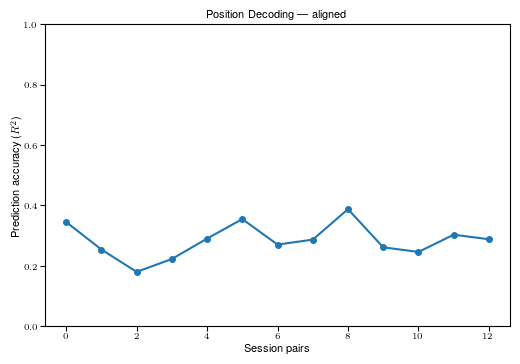

In [8]:
if "__file__" not in dir():
    _,ax = plt.subplots(dpi=100)
    ax.plot(pop_score_across,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs');
    ax.set_ylabel('Prediction accuracy ($R^2$)');
    ax.set_title('Position Decoding --- aligned');

## Without alignment

In [9]:
if "__file__" not in dir():

    warnings.filterwarnings("ignore")
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[1], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))

        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
        # print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')

        # train the decoder
        U,V = X1[goodIndex,:], X2[goodIndex,:]
        Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
        reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        reg_z.fit(U, Y_train_z)
        # test the decoder
        Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
        reg_latent_scores.append((id1,testId,(x_score,y_score,z_score)))
    warnings.filterwarnings("default")

    pop_latent_score = []
    for _,_,scores in reg_latent_scores:
        pop_latent_score.append(np.mean(scores))
    pop_latent_score = np.array(pop_latent_score)

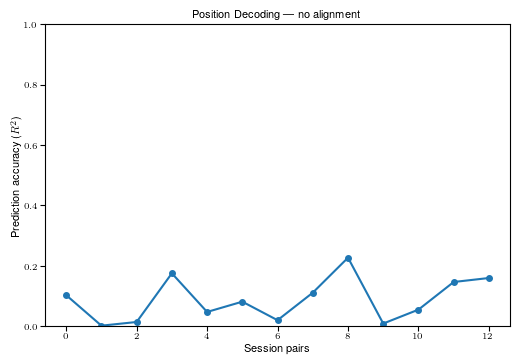

In [10]:
if "__file__" not in dir():

    _,ax = plt.subplots(dpi=100)
    ax.plot(pop_latent_score,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs');
    ax.set_ylabel('Prediction accuracy ($R^2$)');
    ax.set_title('Position Decoding --- no alignment');

# histograms

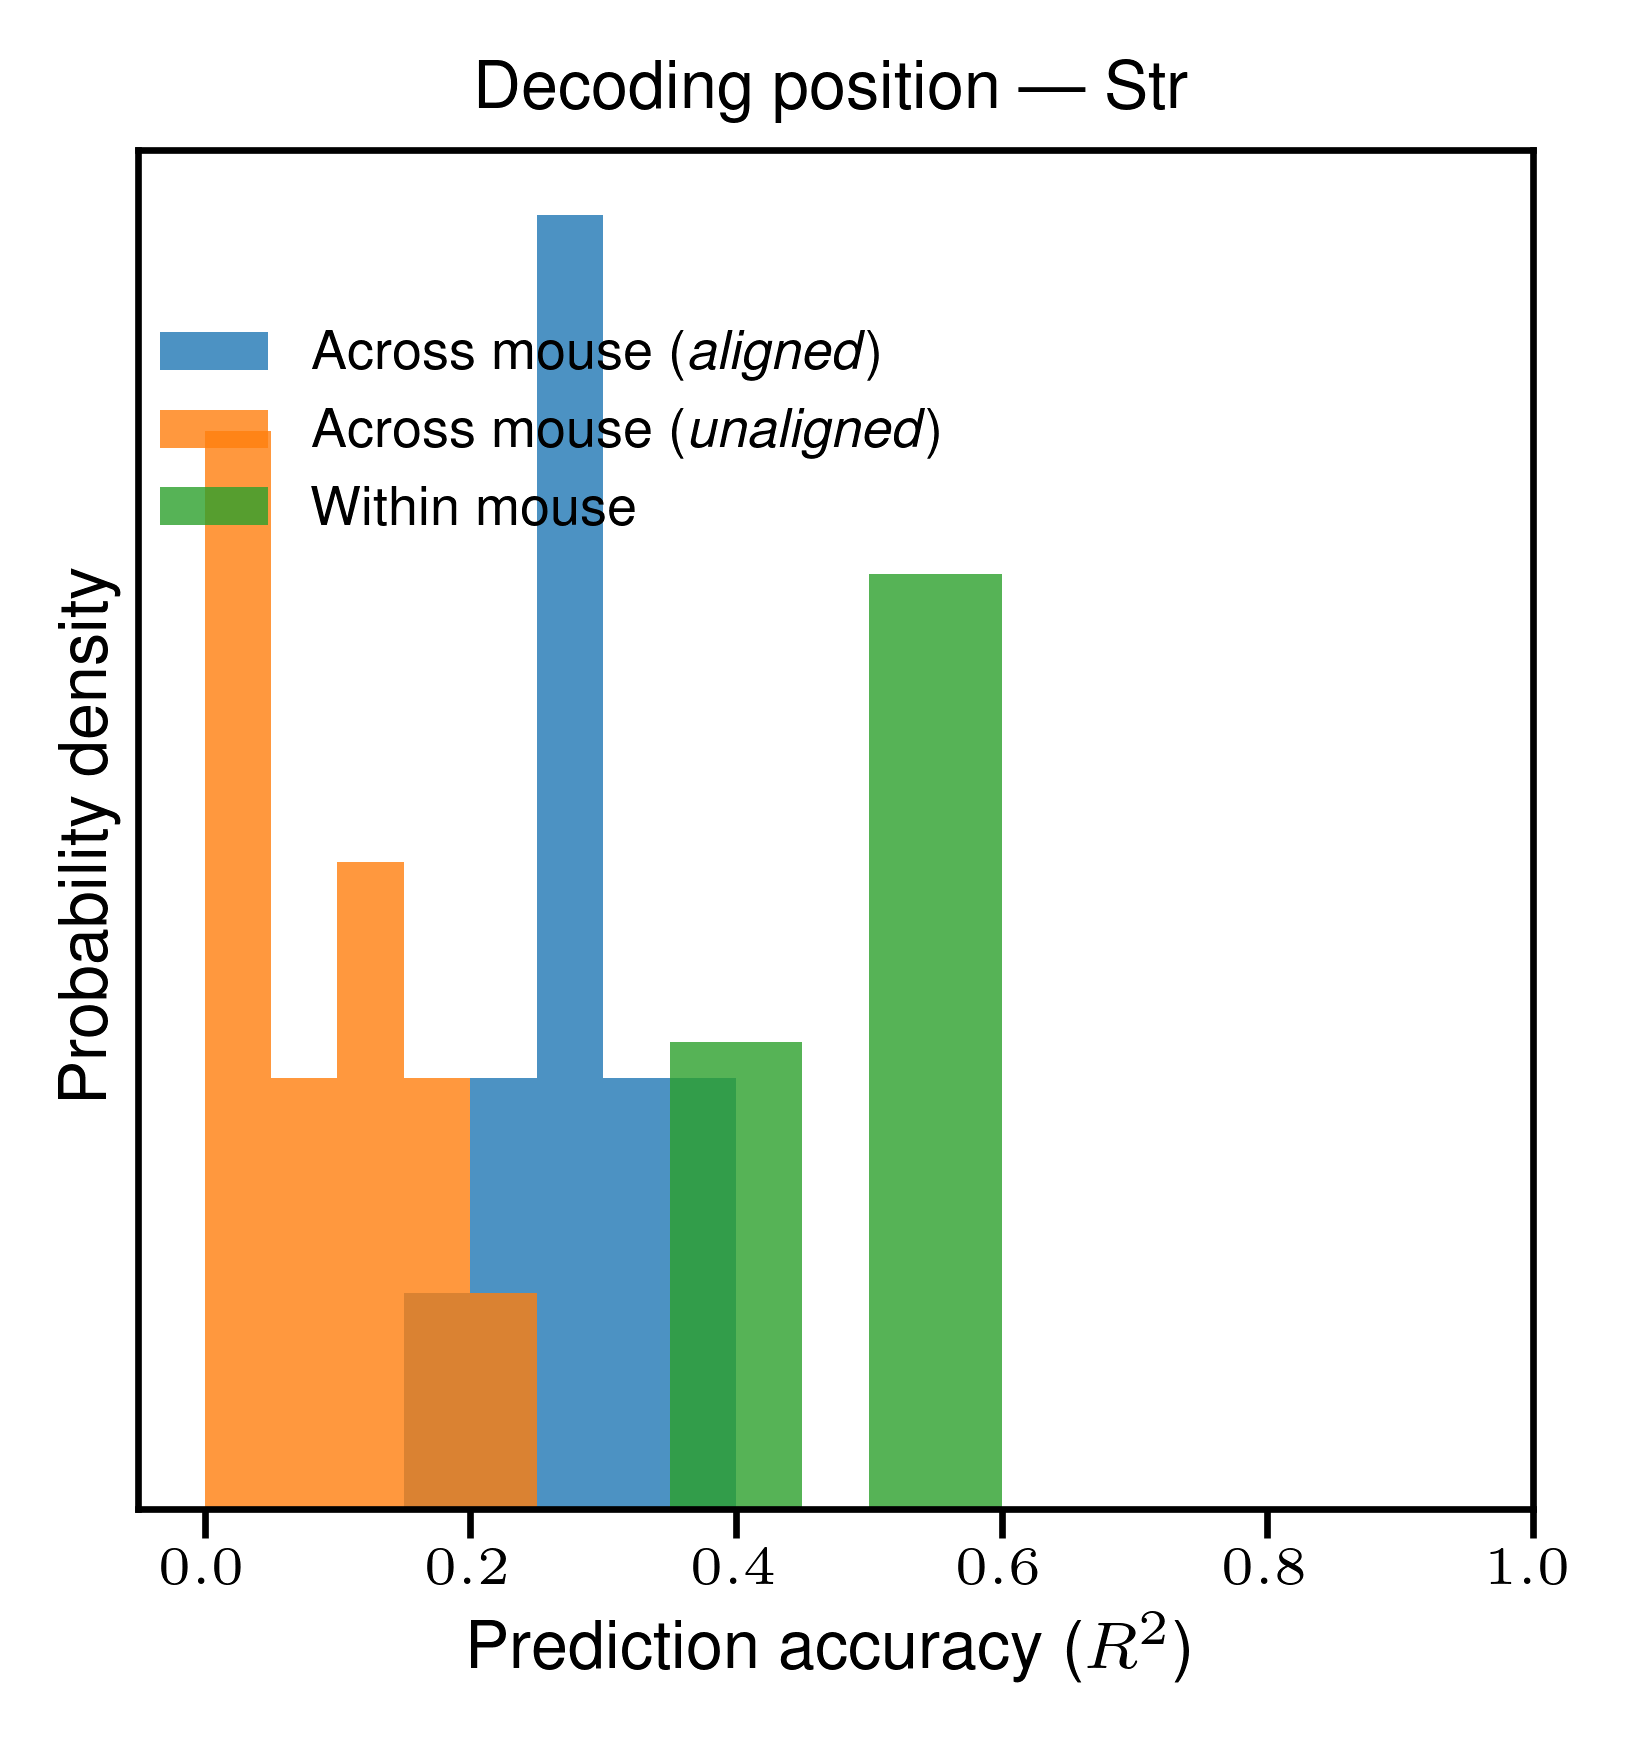

In [11]:
if "__file__" not in dir():

    fig,ax = plt.subplots(figsize=(3,3))

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label=r'Across mouse (\textit{aligned})', alpha=.8)
    ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across mouse (\textit{unaligned})', alpha=.8)
    # ax.hist(pop_score2, bins=bins, density=True, label='aligned across days', alpha=.8)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within mouse', alpha=.8)

    ax.set_title('Decoding position --- Str')
    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Probability density')
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc=(0,.7))

    fig.savefig(params.figPath / 'mouse-STR-decode.pdf', format='pdf', bbox_inches='tight')

# Plot Str decoding vs MCx decoding in mice

In [8]:
def get_full_mouse_data():
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str


def plot_mouse_aligned_decoding(AllDFs, area_code=1):
   
    aligned_score = {}
    for i, df1 in enumerate(tqdm(AllDFs)):
        animal1 = df1.mouse[0]

        aligned_score[df1.file[0]] = {}
        for j, df2 in enumerate(AllDFs):
            if j < i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            
            AllData, AllVel = defs.get_data_array_and_vel([df1, df2], defs.exec_epoch_decode,
                                                          area=defs.areas[area_code], n_components=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = AllData1.shape
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,3))
            AllVel2 = AllVel2.reshape((-1,n_time,3))

            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()

    return aligned_score



In [9]:
allDFs_M1, allDFs_Str = get_full_mouse_data()
str_align = plot_mouse_aligned_decoding(allDFs_Str, area_code=1)
m1_align = plot_mouse_aligned_decoding(allDFs_M1, area_code=0)

/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin 

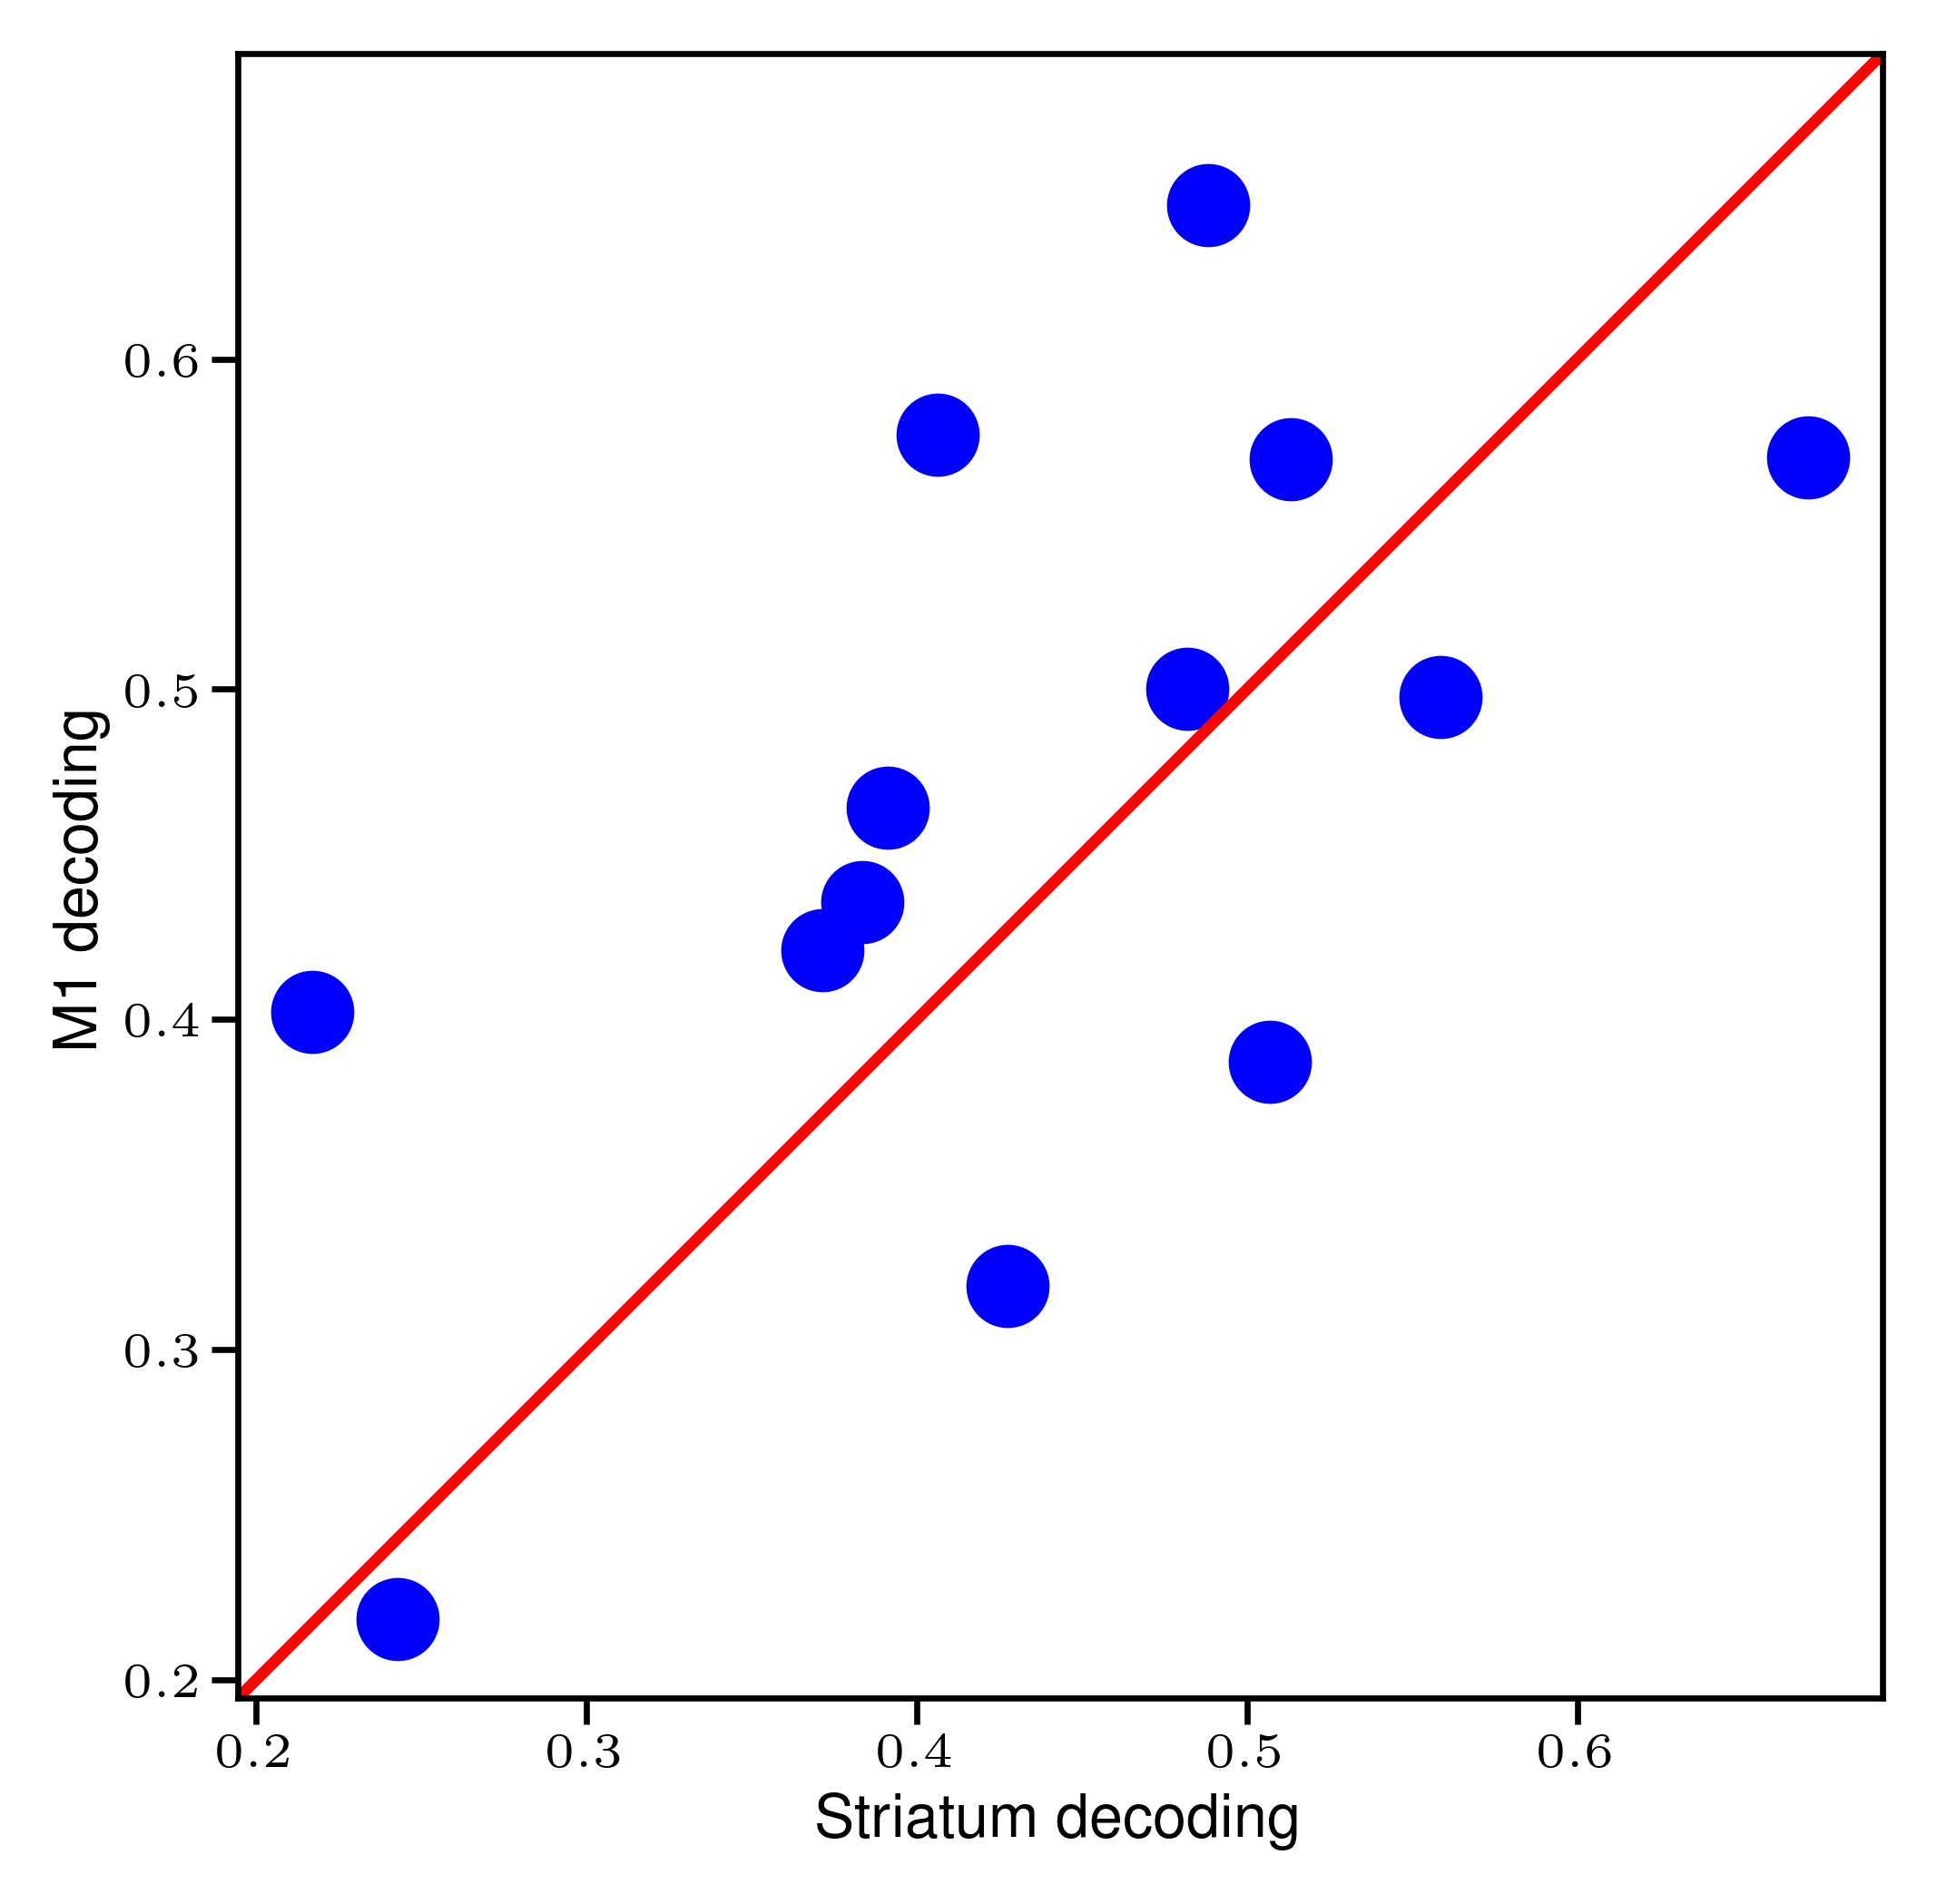

In [23]:
set_rc()
fig, ax = plt.subplots()

for key1,val in m1_align.items():
    for key2 in val:
        ax.plot(str_align[key1][key2], m1_align[key1][key2], 
                marker = 'o', color = 'b', ms = 10)
ax.axline([0, 0], [1, 1], color='r', transform = ax.transAxes)

ax.set_aspect(1)
xmin, xmax, ymin, ymax = ax.axis()
ax.set_xlim([min(xmin, ymin), max(xmax, ymax)])
ax.set_ylim([min(xmin, ymin), max(xmax, ymax)])
ax.set_xlabel('Striatum decoding')
ax.set_ylabel('M1 decoding')

fig.savefig(params.figPath / 'str-m1-decoding.pdf', format='pdf', bbox_inches='tight')

## Test window size effect on LSTM decoding

In [2]:
def get_full_mouse_data():
   
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [3]:
def plot_str_decoding():
    
    defs = params.mouse_defs

    #=========================
    within_score = {}
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]

        AllData, AllVel = defs.get_data_array_and_vel([df1], __exec_epoch_decode, area=defs.areas[1],
                                                    n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        *_,n_time,n_comp = AllData.shape
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        # resizing
        X1 = AllData1.reshape((-1, n_time, n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))

        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model.fit(x_train=x_train, y_train=y_train, epochs = 10)
            lstm_model.predict(x_test, y_test)
            fold_score.append(lstm_model.score)
        fold_score = np.median(fold_score)
        within_score[df1.file[0]] = fold_score


        # aligned_score[df1.file[0]] = {}
        # unaligned_score[df1.file[0]] = {}
        # for j, df2 in enumerate(AllDFs):
        #     if j < i: continue
        #     animal2 = df2.mouse[0]
        #     if animal1 == animal2: continue
            
        #     #================================
        #     # Unaligned
        #     AllData, AllVel = defs.get_data_array_and_vel([df1, df2], defs.exec_epoch_decode,
        #                                                   area=defs.areas[1], n_components=defs.n_components)

        #     # adding history
        #     AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        #     AllData = AllData[...,defs.MAX_HISTORY:,:]
        #     AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        #     AllData1 = AllData[0,...]
        #     AllData2 = AllData[1,...]
        #     AllVel1 = AllVel[0,...]
        #     AllVel2 = AllVel[1,...]
        #     # resizing
        #     _,n_trial,n_time,n_comp = AllData1.shape
        #     X1 = AllData1.reshape((-1,n_comp))
        #     X2 = AllData2.reshape((-1,n_comp))
        #     AllVel1 = AllVel1.reshape((-1,n_time,3))
        #     AllVel2 = AllVel2.reshape((-1,n_time,3))

        #     *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        #     U = U.reshape((-1,n_time,n_comp))
        #     V = V.reshape((-1,n_time,n_comp))
        #     X1 = X1.reshape((-1,n_time,n_comp))
        #     X2 = X2.reshape((-1,n_time,n_comp))

        #     lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
        #     lstm_model.fit(x_train=U, y_train=AllVel1)
        #     lstm_model.predict(V, AllVel2)
        #     aligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()

        #     #================================
        #     # Unaligned
        #     lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
        #     lstm_model.fit(x_train=X1, y_train=AllVel1)
        #     lstm_model.predict(X2, AllVel2)
        #     unaligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()


    # return within_score, aligned_score, unaligned_score
    #======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    # pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    # pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    # ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
    #             color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    # ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
    #             color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    # ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
    #             color=params.colors.UpperCC, fmt='-o', capsize=1.5)


    # for file1, nested_dict in aligned_score.items():
    #     wi_val1 = within_score[file1]
    #     for file2, al_val in nested_dict.items():
    #         wi_val2 = within_score[file2]
    #         unal_val = unaligned_score[file1][file2]
    #         ax.plot([0,1,2], [unal_val, al_val, wi_val1],
    #                 color='gray', lw=.2, zorder=6, marker = '.', ms=.1)
    #         ax.plot([1,2], [al_val, wi_val2],
    #                 color='gray', lw=.2, zorder=6, marker = '.', ms=.1)

    # ax.set_xlim([-0.2,2.2])
    # ax.set_xticks([0,1,2])
    # ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
    #                     'Across\n' r'(\textit{aligned})',
    #                     'Within'])
    # ax.set_ylabel('Prediction accuracy ($R^2$)')
    # ax.set_ylim([-.05,1])
    # # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_bounds([0,2])
    # ax.spines['left'].set_bounds([0,1])

    return pop_within

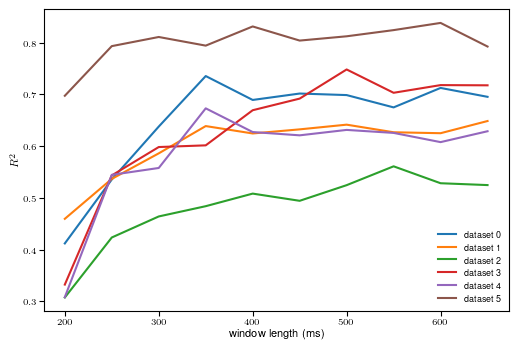

In [23]:
if "__file__" not in dir():

    _, AllDFs = get_full_mouse_data()
    clear_output()

    win_range = np.arange(.6, .1, -.05)
    dec_data = []
    for i in win_range:
        WINDOW_exec = (-.05, i)  # sec
        __exec_epoch_decode = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                        rel_start=int(WINDOW_exec[0]/defs.BIN_SIZE) - defs.MAX_HISTORY,
                                        rel_end=int(WINDOW_exec[1]/defs.BIN_SIZE)
                                        )
        dec_data.append(plot_str_decoding())

    dec_data = np.array(dec_data)

    
    ax = plt.figure(dpi=100).gca()
    ax.plot((win_range+.05)*1000, dec_data, label=[f'dataset {i}' for i in range(6)])
    ax.set_xlabel('window length (ms)')
    ax.set_ylabel('$R^2$')
    ax.legend()